# Nonbinary Comparison
a. stein 6.22.2023

Comparing drought networks through nonbinary data

In [1]:
import pickle
import numpy as np

import sys
sys.path.append('../../../')
import ndrought.drought_network as dnet
import ndrought.wrangle_v11 as dnw
import ndrought.plotting as dnp

import matplotlib as mpl
import matplotlib.pyplot as plt

import pandas as pd
import xarray as xr

from tqdm.autonotebook import tqdm

/pool0/data/steinjao/drought/drought_impact/notebooks/explore/drought_network/../../../ndrought/wrangle.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Load in Data

In [2]:
dnet_path = '/pool0/home/steinadi/data/drought/drought_impact/data/drought_measures/ndrought_products/CONUS_105W/individual_dnet'

In [3]:
exp_tag = 'f25k_d1_rt20p_paired'

In [4]:
usdm_net = dnet.DroughtNetwork.unpickle(f'{dnet_path}/USDM_net_{exp_tag}.pickle')

In [5]:
spi30d_net = dnet.DroughtNetwork.unpickle(f'{dnet_path}/spi_30d_net_{exp_tag}.pickle')

In [6]:
spi180d_net = dnet.DroughtNetwork.unpickle(f'{dnet_path}/spi_180d_net_{exp_tag}.pickle')

In [7]:
paired_ds = xr.open_dataset('/pool0/home/steinadi/data/drought/drought_impact/data/drought_measures/ndrought_products/CONUS_105W/paired_ds/usdm_spi_paired.nc')

## Pulling out data via masks

In [8]:
test_node = usdm_net.nodes[0]

In [9]:
usdm_net.data.shape

(1149, 702, 525)

In [10]:
empty_data = np.zeros(usdm_net.data.shape[1:])
empty_data.shape

(702, 525)

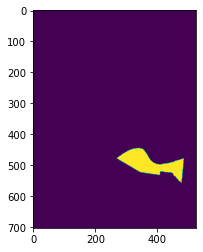

In [11]:
test_mask = empty_data.copy()
for coord in test_node.coords:
    test_mask[coord[0], coord[1]] += 1

plt.imshow(test_mask)

Double check that that looks right

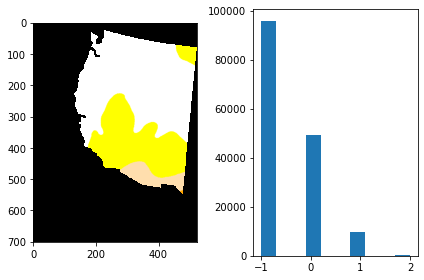

In [12]:
test_array = paired_ds['USDM'].values[test_node.time, :, :]
fig, ax = plt.subplots(1, 2)
ax[0].imshow(test_array, vmin=-1, vmax=4, cmap=dnp.usdm_cmap())
ax[0].set_facecolor('k')
ax[1].hist(test_array.ravel())
plt.tight_layout()

Yeeup

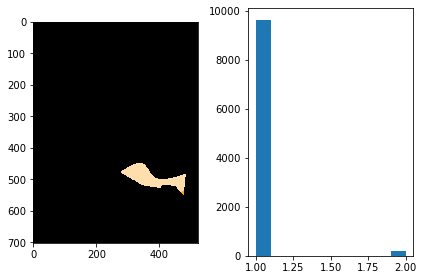

In [13]:
test_ma = np.ma.masked_where(test_mask==0, test_array)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(test_ma, vmin=-1, vmax=4, cmap=dnp.usdm_cmap())
ax[0].set_facecolor('k')
ax[1].hist(test_ma.ravel())
plt.tight_layout()

Lovely, that worked.

So one thing about doing cross-category comparison, is that it is challenging the categories as determined from the USDM here: https://droughtmonitor.unl.edu/About/AbouttheData/DroughtClassification.aspx

Let's compute a weighted centroid

So I've got a list of coordinates

In [14]:
test_node.coords

array([[444, 335],
       [444, 338],
       [444, 339],
       ...,
       [554, 478],
       [555, 477],
       [555, 478]])

and I've got the array

ooo, I found a package function

In [15]:
import scipy

In [16]:
test_com = scipy.ndimage.center_of_mass(test_ma)
test_com

(495.7040551338394, 381.1549141030763)

That was easy

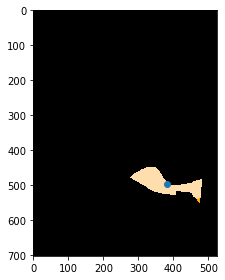

In [17]:
fig, ax = plt.subplots(1, 1)
ax.imshow(test_ma, vmin=-1, vmax=4, cmap=dnp.usdm_cmap())
ax.set_facecolor('k')
ax.scatter(test_com[1], test_com[0]) #idk why I have to flip them ...
plt.tight_layout()

In [18]:
usdm_nodes_com = {}

for node in tqdm(usdm_net.nodes):
    node_mask = empty_data.copy()
    for coord in node.coords:
        node_mask[coord[0], coord[1]] += 1
    node_array = paired_ds['USDM'].values[node.time, :, :]
    node_ma = np.ma.masked_where(node_mask==0, node_array)
    node_com = scipy.ndimage.center_of_mass(node_ma)
    usdm_nodes_com[node.id] = node_com

  0%|          | 0/1814 [00:00<?, ?it/s]

In [ ]:
usdm_nodes_com

{0: (495.7040551338394, 381.1549141030763),
 1: (495.7040551338394, 381.1549141030763),
 2: (497.0295612400474, 393.5703032356429),
 3: (498.6731207289294, 397.3734010863851),
 4: (504.07708172209334, 436.2281515854602),
 5: (503.4873245566315, 438.4070286149494),
 6: (507.49859223895214, 438.7357081650141),
 7: (503.5922630947621, 431.60115953618555),
 8: (502.8201347524656, 431.31461771311393),
 9: (502.5387446533373, 434.41848204516066),
 10: (503.1018163966618, 434.9269513991163),
 11: (501.5380806997277, 422.64947602937536),
 12: (500.29714556811894, 420.0088558551435),
 13: (133.81422464049749, 409.8068402642829),
 14: (482.3013928067701, 421.1105870944993),
 15: (123.33716265499635, 443.958242159008),
 16: (482.3013928067701, 421.1105870944993),
 17: (110.39182634004366, 443.5816153286442),
 18: (479.57955162797435, 424.5620223823838),
 19: (123.40362595419847, 442.7977099236641),
 20: (477.5168238282473, 419.9393159121751),
 21: (124.62077118952347, 423.2504547108039),
 22: (47

In [ ]:
spi30d_nodes_com = {}
empty_data = np.zeros(spi30d_net.data.shape[1:])

for node in tqdm(spi30d_net.nodes):
    node_mask = empty_data.copy()
    for coord in node.coords:
        node_mask[coord[0], coord[1]] += 1
    node_array = paired_ds['spi_30d'].values[node.time, :, :]
    node_ma = np.ma.masked_where(node_mask==0, node_array)
    node_com = scipy.ndimage.center_of_mass(node_ma)
    spi30d_nodes_com[node.id] = node_com

  0%|          | 0/2262 [00:00<?, ?it/s]

In [ ]:
spi180d_nodes_com = {}
empty_data = np.zeros(spi180d_net.data.shape[1:])

for node in tqdm(spi180d_net.nodes):
    node_mask = empty_data.copy()
    for coord in node.coords:
        node_mask[coord[0], coord[1]] += 1
    node_array = paired_ds['spi_180d'].values[node.time, :, :]
    node_ma = np.ma.masked_where(node_mask==0, node_array)
    node_com = scipy.ndimage.center_of_mass(node_ma)
    spi180d_nodes_com[node.id] = node_com

  0%|          | 0/1930 [00:00<?, ?it/s]

Let's combine this with the drought tracks to get new weighted centroid tracks

## Load in tracks

In [ ]:
dt_path = '/pool0/home/steinjao/data/drought/drought_impact/data/drought_measures/ndrought_products/CONUS_105W/drought_tracks'

In [ ]:
exp_tag = 'f25k_d1_rt20p_paired'
#exp_tag = 'f25k_d2_rt20p_paired'

In [ ]:
usdm_dtd = dnw.convert_pickle_to_dtd(f'{dt_path}/USDM_tracks_{exp_tag}.pickle')

In [ ]:
usdm_dtd = dnw.prune_tracks(usdm_dtd)

In [ ]:
spi30d_dtd = dnw.convert_pickle_to_dtd(f'{dt_path}/spi_30d_tracks_{exp_tag}.pickle')

In [ ]:
spi30d_dtd = dnw.prune_tracks(spi30d_dtd)

In [ ]:
spi180d_dtd = dnw.convert_pickle_to_dtd(f'{dt_path}/spi_180d_tracks_{exp_tag}.pickle')

In [ ]:
spi180d_dtd = dnw.prune_tracks(spi180d_dtd)

## Create COM track

In [ ]:
usdm_com_x = []
usdm_com_y = []

for track in usdm_dtd['id']:
    track_x = []
    track_y = []
    for id in track:
        (y, x) = usdm_nodes_com[id]
        track_x.append(x)
        track_y.append(y)
    usdm_com_x.append(np.array(track_x))
    usdm_com_y.append(np.array(track_y))

In [ ]:
spi30d_com_x = []
spi30d_com_y = []

for track in spi30d_dtd['id']:
    track_x = []
    track_y = []
    for id in track:
        (y, x) = spi30d_nodes_com[id]
        track_x.append(x)
        track_y.append(y)
    spi30d_com_x.append(np.array(track_x))
    spi30d_com_y.append(np.array(track_y))

In [ ]:
spi180d_com_x = []
spi180d_com_y = []

for track in spi180d_dtd['id']:
    track_x = []
    track_y = []
    for id in track:
        (y, x) = spi180d_nodes_com[id]
        track_x.append(x)
        track_y.append(y)
    spi180d_com_x.append(np.array(track_x))
    spi180d_com_y.append(np.array(track_y))

In [ ]:
def centroid_distance(a_t, a_x, a_y, a_id, b_t, b_x, b_y, b_id):

    intersect_distance = []

    intersect_ab_t = np.intersect1d(a_t, b_t)
    if len(intersect_ab_t) > 0 :
        local_a = []
        local_b = []

        for ab in intersect_ab_t:
            local_a.append((np.argwhere(a_t == ab).flatten(), ab))
            local_b.append((np.argwhere(b_t == ab).flatten(), ab))


        for e_a, e_b in zip(local_a, local_b):
            for sub_e_a in e_a[0]:
                for sub_e_b in e_b[0]:
                    sub_a_x = a_x[sub_e_a]
                    sub_a_y = a_y[sub_e_a]
                    sub_a_t = a_t[sub_e_a]
                    sub_a_id = a_id[sub_e_a]

                    sub_b_x = b_x[sub_e_b]
                    sub_b_y = b_y[sub_e_b]
                    sub_b_t = b_t[sub_e_b]
                    sub_b_id = b_id[sub_e_b]

                    if sub_a_t != sub_b_t:
                        raise Exception('Temporal Error')

                    sub_del_x = sub_a_x - sub_b_x
                    sub_del_y = sub_a_y - sub_b_y
                    sub_distance = np.sqrt(np.power(sub_del_x, 2)+np.power(sub_del_y, 2))

                    intersect_distance.append((sub_a_t, sub_a_id, sub_b_id, sub_distance))
    return intersect_distance

In [ ]:
centroid_distances_usdm_spi30d = []

for usdm_t, usdm_x, usdm_y, usdm_id in zip(usdm_dtd['t'], usdm_com_x, usdm_com_y, usdm_dtd['id']):
    for spi30d_t, spi30d_x, spi30d_y, spi30d_id in zip(spi30d_dtd['t'], spi30d_com_x, spi30d_com_y, spi30d_dtd['id']):
        centroid_distances_usdm_spi30d.append(centroid_distance(
            usdm_t, usdm_x, usdm_y, usdm_id,
            spi30d_t, spi30d_x, spi30d_y, spi30d_id
        ))

In [ ]:
centroid_distances_usdm_spi30d

[[(6, 0, 10, 249.43387055416665),
  (7, 1, 11, 229.63510985250096),
  (7, 1, 11, 229.63510985250096),
  (8, 2, 13, 265.98972643918904),
  (9, 3, 16, 267.24985299744844),
  (10, 4, 18, 280.0640472486127),
  (11, 5, 21, 315.19314303134985)],
 [(8, 2, 14, 364.79400340902896), (9, 3, 17, 368.2531135500611)],
 [(10, 4, 20, 115.43158250414663),
  (11, 5, 23, 121.7523686099217),
  (11, 5, 23, 121.7523686099217),
  (12, 6, 25, 127.91063551708407),
  (12, 6, 27, 115.14074337566016),
  (13, 7, 28, 89.87057672000562),
  (14, 8, 30, 81.34052960689533),
  (15, 9, 31, 78.31846446177855)],
 [(17, 11, 34, 250.71201598915252), (18, 12, 37, 251.64755190084546)],
 [(23, 22, 40, 474.8755253671711), (24, 24, 42, 474.45375597554437)],
 [(24, 24, 43, 45.81210911383849)],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 

In [ ]:
min_distance = (np.nan, np.nan, np.nan, np.inf)

for cd in centroid_distances_usdm_spi30d:
    if len(cd) > 0:
        for local in cd:
            distance = local[3]
            if distance < min_distance[3]:
                min_distance = local

In [ ]:
min_distance

(976, 1539, 1950, 10.557455027272082)

In [ ]:
usdm_node = usdm_net.nodes[min_distance[1]]
usdm_array = usdm_net.to_array(id=usdm_node.id)
usdm_node

time: 976, id: 1539

In [ ]:
spi30d_node = spi30d_net.nodes[min_distance[2]]
spi30d_array = spi30d_net.to_array(id=spi30d_node.id)
spi30d_node

time: 976, id: 1950

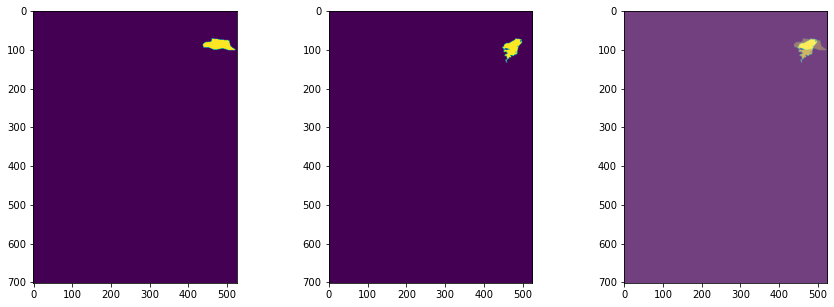

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))

ax[0].imshow(usdm_array[0, :, :])
ax[1].imshow(spi30d_array[0, :, :])
ax[2].imshow(usdm_array[0, :, :], alpha=0.5)
ax[2].imshow(spi30d_array[0, :, :], alpha=0.5)

OOOOOOOOOOOOOOOO